# Projeto 3 -  Clusterização

## Informações do Projeto
DataSet:<br /><br />https://www.kaggle.com/new-york-city/nyc-property-sales
     nyc-property-sales

Grupo:
      Antonio Andraues<br />
      Lucca Delchiaro <br/ >
      Joao Edvirges.<br /><br />


In [58]:
import math
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import numpy as np
from sklearn.mixture import GMM
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import *
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm

In [59]:
dados=pd.read_csv("nyc-rolling-sales.csv")
dados


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
5,9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,,C4,516 EAST 12TH STREET,...,20,0,20,2581,9730,1900,2,C4,-,2017-07-20 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00
7,11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,,C7,520 EAST 14TH STREET,...,44,2,46,5163,21007,1900,2,C7,-,2017-07-20 00:00:00
8,12,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,,D5,141 AVENUE D,...,15,0,15,1534,9198,1920,2,D5,-,2017-06-20 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00


    A partir do dataset escolhido, a equipe percebeu que há questões de sensibilidades em relação aos algoritmos disponíveis. Partindo do princípio de que o dataset está possui informações de boa qualidade, achou-se melhor optar dentre DBSCAN, K-Means e Mean Shift, o algoritmo Mean Shift por ter mais afinidade as nossas váriaveis.(doc:http://scikit-learn.org/stable/modules/clustering.html). Numa rápida lida no data base, viu-se a necessidade de definir quais regiões possuem high budget e low budget. Para isso, um elemento necessário e identificar para qual centróide cada ponto está convergindo, dando uma idéia de agrupamento e assim definindo cada bairro com sua income.Porém para esse cluster ficar apresentável, sabe-se que um processo de smoothing será necessário, pois mesmo dentro de divisões via renda, ainda assim dentro de uma classe, possui-se diferenças grandes nas rendas e nas depesas.Por isso a escolha do mean shift, que vai pegar cada ponto convergindo e dar uma suavizada nesse resultados, mostrando mais definido cada região.(Doc:https://www.youtube.com/watch?v=yTsslXB5v1s,https://www.youtube.com/watch?v=yhz8Fm0ymm8)
   O mean shift e utilizado em suavização de pixels, diminuindo as diferenças que cada cor possui, tornando a imagem de saída menos discrepante. 
   
   Segue o exemplo de um cluster via Mean Shift:
  http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html
  
  A biblioteca que a equipe vai importar e a própria do scikit learn.

In [60]:
dados2=dados.loc[:,['NEIGHBORHOOD','SALE PRICE','BLOCK','TAX CLASS AT PRESENT','GROSS SQUARE FEET','LAND SQUARE FEET','YEAR BUILT']] #selecionando os subsets que vamos trabalhar
dados2=dados2.rename(columns={'SALE PRICE': 'SALE_PRICE'})#facilitar a representacao da coluna
dados2=dados2.rename(columns={'TAX CLASS AT PRESENT': 'TAX_CLASS_AT_PRESENT'})
dados2=dados2.rename(columns={'GROSS SQUARE FEET': 'GROSS_SQUARE_FEET'})
dados2=dados2.rename(columns={'LAND SQUARE FEET': 'LAND_SQUARE'})
dados2=dados2.rename(columns={'YEAR BUILT': 'YEAR_BUILT'})
dados2.SALE_PRICE[2] #Formato do preco nao completado
dados2=dados2.loc[dados2.SALE_PRICE!=' -  ']
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET!=' -  ']#retirada do formato "Nao completado"
dados2=dados2.loc[dados2.LAND_SQUARE!=' -  ']
dados2.SALE_PRICE=dados2.SALE_PRICE.astype("float")
dados2.GROSS_SQUARE_FEET=dados2.GROSS_SQUARE_FEET.astype("float")
dados2.LAND_SQUARE=dados2.LAND_SQUARE.astype("float")
dados2.YEAR_BUILT=dados2.YEAR_BUILT.astype("int")
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='3'] #retirando fabricas e terrenos
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='4']
dados2.SALE_PRICE=dados2.SALE_PRICE  #preco por metro quadrado
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE>=1]#filtrando casa abaixo do valor de 10milhoes de dollares
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE<=10000000]
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET<=10000]#outliers
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET>0]#NO SENSE
dados2=dados2.loc[dados2.LAND_SQUARE<=20000]#outliers
dados2=dados2.loc[dados2.YEAR_BUILT>0]#NO SENSE
dados2=dados2.dropna()
dados2=dados2.reset_index()
dados2.head(4)

,index,NEIGHBORHOOD,SALE_PRICE,BLOCK,TAX_CLASS_AT_PRESENT,GROSS_SQUARE_FEET,LAND_SQUARE,YEAR_BUILT
0,0,ALPHABET CITY,6625000.0,392,2A,6440.0,1633.0,1900
1,3,ALPHABET CITY,3936272.0,402,2B,6794.0,2272.0,1913
2,4,ALPHABET CITY,8000000.0,404,2A,4615.0,2369.0,1900
3,6,ALPHABET CITY,3192840.0,406,2B,4226.0,1750.0,1920


Ao filtrar os da

In [72]:
n=3 #numeros de bairros
bairros = dados2.NEIGHBORHOOD[~dados2.NEIGHBORHOOD.duplicated(keep='first')] #Nomes de todos os bairros uma unica vez
primeirosB=bairros[:n] #primeiros 10 bairros para analize
primeirosBairros=[] #colocando os nomes em uma lista
for i in primeirosB:
    primeirosBairros.append(i)
        
Precos=[]         #pegando os precos para cada bairro
for u in primeirosBairros:  
    ppp=dados2.loc[dados2.NEIGHBORHOOD==u]
    pp=ppp  #Serve para analizar cada bairro individualmente
    for c in range(0,len(ppp)):
        preco=ppp.SALE_PRICE
    Precos.append(preco)
# dados2.plot.scatter(x='LAND_SQUARE_FEET',y='BLOCK',z='SALE_PRICE',norm=1)

# dd=pd.DataFrame(Precos,columns=[primeirosBairros]) #Gerado randomicamente so para teste    

# Plot
# fig, ax = plt.subplots()
# ax.legend()

# plt.show()

# dd=pd.DataFrame(np.random.rand(len(preco), n),columns=[primeirosBairros]) #Gerado randomicamente so para teste
# print(dd.max())

# ax = dd.plot.scatter(x=primeirosBairros[0], y=primeirosBairros[0], color='DarkBlue', label=primeirosBairros[0]);
# dd.plot.scatter(x=primeirosBairros[1], y=primeirosBairros[1], color='DarkGreen', label=primeirosBairros[1], ax=ax);

# plt.show()



In [73]:
# for i in bairros:
df.head()

,GSF,BL,SP
0,6440.0,392,6625000.0
1,6794.0,402,3936272.0
2,4615.0,404,8000000.0
3,4226.0,406,3192840.0
4,3360.0,391,3300000.0


formula: y = -53.5662x + 1085000.0


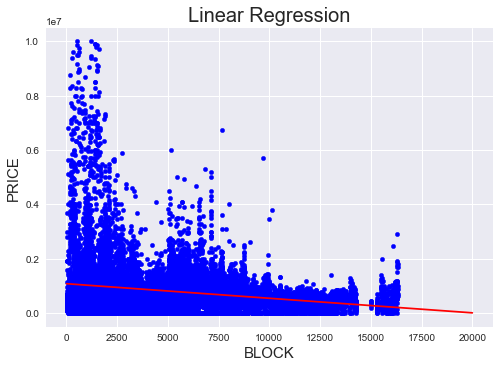

In [74]:

df4 = pd.DataFrame() #NOIA FAZER 
df4['BLOCK'] = dados2.BLOCK
df4['PRICE'] = dados2.SALE_PRICE
npMatrix = np.matrix(df4)
X, Y = npMatrix[:,0], npMatrix[:,1]
# mdl = LinearRegression().fit(X,Y) # either this or the next line
mdl = linear_model.LinearRegression().fit(df4[['BLOCK']],df4.PRICE)
m = -53.5662
b = 1.085e+06
print("formula: y = {0}x + {1}".format(m, b))
df4.plot.scatter(x='BLOCK',y='PRICE',color='blue')
lista=[]
t=[]
for i in range (20000):
    lista.append(m*i+b)
    t.append(i)
plt.plot(t,lista,'r')
plt.title('Linear Regression', fontsize = 20)
plt.xlabel('BLOCK', fontsize = 15)
plt.ylabel('PRICE', fontsize = 15)
plt.show()

plt.show()

In [75]:
X = df4['PRICE']
Y = df4["BLOCK"]
Y = sm.add_constant(Y)
model = sm.OLS(X,Y)
results1 = model.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1855.
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        23:54:58   Log-Likelihood:            -4.0637e+05
No. Observations:               27131   AIC:                         8.127e+05
Df Residuals:                   27129   BIC:                         8.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.085e+06   8529.052    127.248      0.000    1.07e+06     1.1e+06
BLOCK        -53.5662      1.244    -43.070      0.000     -56.004     -51.128
==============================================================================
Omnibus:                    25948.724   Durbin-Watson:                   0.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1387592.028
Skew:                           4.644   Prob(JB):                         0.00
Kurtosis:                      36.781   Cond. No.                     1.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024F5883C8D0>]], dtype=object)

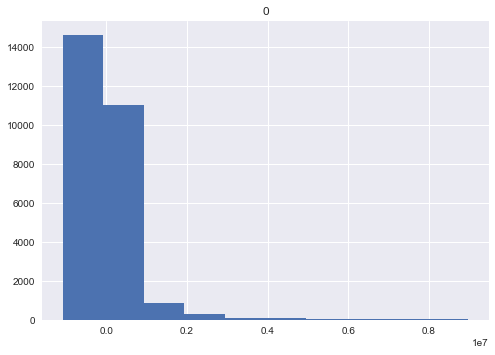

In [77]:
e=[]
for i in range (len(df4['PRICE'])):
    r=df4['PRICE'][i]-(1.085e+06+-53.5662*df4['BLOCK'][i])
    e.append(r)
e=pd.DataFrame(e)
e.hist()

In [ ]:
X=[]
Y=[]
import random
my_randoms = random.sample(range(len(dados2)),k=1000)
for i in my_randoms:
    h=dados2.loc[i,"SALE_PRICE"]
    c=dados2.loc[i,"BLOCK"]
    X.append(h)
    Y.append(c)
data1000=pd.DataFrame()
data1000["SALE_PRICE"]=X
data1000["BLOCK"]=Y
data1000.plot.scatter(x="BLOCK",y="SALE_PRICE")
# X=list(h)
# X=pd.Series(X)
# X.hist(normed=True)

In [65]:
X = data1000['SALE_PRICE']
Y = data1000["BLOCK"]
Y = sm.add_constant(Y)
model = sm.OLS(X,Y)
results1000 = model.fit()
results1000.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE_PRICE   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     67.93
Date:                Sun, 19 Nov 2017   Prob (F-statistic):           5.28e-16
Time:                        23:54:38   Log-Likelihood:                -15104.
No. Observations:                1000   AIC:                         3.021e+04
Df Residuals:                     998   BIC:                         3.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.157e+06    5.2e+04     22.241      0.000    1.06e+06    1.26e+06
BLOCK        -61.4223      7.452     -8.242      0.000     -76.046     -46.798
==============================================================================
Omnibus:                     1109.035   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79754.766
Skew:                           5.438   Prob(JB):                         0.00
Kurtosis:                      45.377   Cond. No.                     1.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

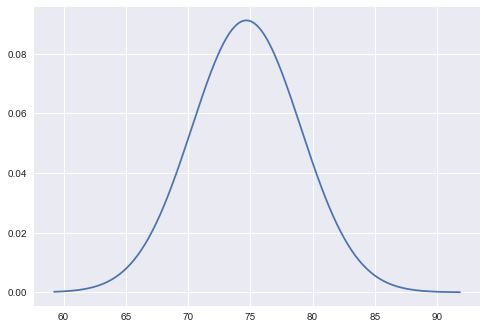

In [66]:
loc=74.67
scale=4.374
N=norm.rvs(loc,scale,1000)
n=np.arange(N.min(),N.max(),0.1)
plt.plot(n,norm.pdf(n,loc,scale))
plt.show()

In [67]:
df = pd.DataFrame()
@interact(rodar_em_x = (0, 360, 20),rodar_em_y = (0, 360, 20))
def f(rodar_em_x=40,rodar_em_y=60):
    df['GSF'] = dados2.GROSS_SQUARE_FEET
    df['BL'] = dados2.BLOCK
    df['SP'] = dados2.SALE_PRICE
    threedee = plt.figure().gca(projection='3d')
    threedee.scatter(df.GSF, df.BL, df.SP)
    threedee.set_xlabel('GROSS_SQUARE_FEET')
    threedee.set_ylabel('BLOCK')
    threedee.set_zlabel('PRICE')
    threedee.view_init(rodar_em_x,rodar_em_y )
    plt.show()


In [68]:
df2 = pd.DataFrame()
@interact(rodar_em_x = (0, 360, 20),rodar_em_y = (0, 360, 20))
def f(rodar_em_x=40,rodar_em_y=60):
    df2['X'] = dados2.LAND_SQUARE
    df2['Y'] = dados2.BLOCK
    df2['Z'] = dados2.SALE_PRICE
    threedee = plt.figure().gca(projection='3d')
    threedee.scatter(df2.X, df2.Y, df2.Z)
    threedee.set_xlabel('LAND_SQUARE_FEET')
    threedee.set_ylabel('BLOCK')
    threedee.set_zlabel('PRICE')
    threedee.view_init(rodar_em_x,rodar_em_y )
    plt.show()


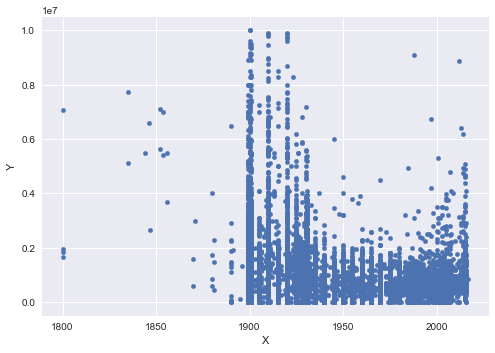

In [69]:
df3 = pd.DataFrame()
df3['X'] = dados2.YEAR_BUILT
df3['Y'] = dados2.SALE_PRICE
df3.plot.scatter(x='X',y='Y')
# df3.plot.set_xlabel('Year Built')
# df3.plot.set_ylabel('Price')
plt.show()

In [70]:

Z = df['SP']
Y = df[['BL','GSF']]
Y = sm.add_constant(Y)

model = sm.OLS(Z,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SP   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     5583.
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        23:54:44   Log-Likelihood:            -4.0259e+05
No. Observations:               27131   AIC:                         8.052e+05
Df Residuals:                   27128   BIC:                         8.052e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.074e+05    1.2e+04     17.316      0.000    1.84e+05    2.31e+05
BL           -27.8504      1.117    -24.944      0.000     -30.039     -25.662
GSF          351.6620      3.767     93.358      0.000     344.279     359.045
==============================================================================
Omnibus:                    22652.894   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1127091.587
Skew:                           3.725   Prob(JB):                         0.00
Kurtosis:                      33.684   Cond. No.                     2.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
Z = df['SP']
Y = df[['BL','GSF']]
Y = sm.add_constant(Y)

model = sm.OLS(Z,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SP   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     5583.
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        23:54:44   Log-Likelihood:            -4.0259e+05
No. Observations:               27131   AIC:                         8.052e+05
Df Residuals:                   27128   BIC:                         8.052e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.074e+05    1.2e+04     17.316      0.000    1.84e+05    2.31e+05
BL           -27.8504      1.117    -24.944      0.000     -30.039     -25.662
GSF          351.6620      3.767     93.358      0.000     344.279     359.045
==============================================================================
Omnibus:                    22652.894   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1127091.587
Skew:                           3.725   Prob(JB):                         0.00
Kurtosis:                      33.684   Cond. No.                     2.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
X = df2['Z']
Y = df2[['Y','X']]
Y = sm.add_constant(Y)
model = sm.OLS(X,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     938.5
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:07:56   Log-Likelihood:            -4.0636e+05
No. Observations:               27131   AIC:                         8.127e+05
Df Residuals:                   27128   BIC:                         8.127e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.051e+06   1.14e+04     92.032      0.000    1.03e+06    1.07e+06
Y            -54.2514      1.252    -43.318      0.000     -56.706     -51.797
X             12.9476      2.852      4.540      0.000       7.358      18.537
==============================================================================
Omnibus:                    26021.599   Durbin-Watson:                   0.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1404720.765
Skew:                           4.663   Prob(JB):                         0.00
Kurtosis:                      36.995   Cond. No.                     1.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# # N = 5 #ESQUECER ESSA PARTE (SO TESTES)
# # arr = np.arange(N*2).reshape(N,2)
# # words=np.array(primeirosBairros)
# df = pd.DataFrame()
# df['X'] = dados2.LAND_SQUARE_FEET
# df['Y'] = dados2.BLOCK
# df['Z'] = dados2.SALE_PRICE
# Xuniques, X = np.unique(df['X'], return_inverse=True)
# Yuniques, Y = np.unique(df['Y'], return_inverse=True)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(X, Y, Z, s=20, c='b')
# ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
#        yticks=range(len(Yuniques)), yticklabels=Yuniques) 
# plt.show()